In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

from tensorflow.python.keras.layers import Layer, Dense, LSTM, Dropout, LayerNormalization, Input
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.python.keras.optimizer_v2 import adam
from keras.callbacks import EarlyStopping
from keras import backend as K
tf.__version__

'2.6.0'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Hyperparameter

In [3]:
batch_size = 32
num_stocks = 31
seq_len = 15
num_features = 10
num_market_features = num_features

beta = 0.01
units = 72
ft_dim = 64
n_heads = 3

## 데이터 업로드

In [4]:
kospi31 = pd.read_csv("/content/drive/MyDrive/programmers/project/data/preprocessed_kospi31_daily_stock_chart.csv")
kospi31

,code,name,date,open,high,low,close,z_d5,z_d10,z_d15,z_d20,z_d25,z_d30
0,U182,kospi50_index,20030102,-0.000572,0.003749,-0.017282,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,U182,kospi50_index,20030103,-0.016228,0.002173,-0.020027,0.044230,-0.021178,-0.021178,-0.021178,-0.021178,-0.021178,-0.021178
2,U182,kospi50_index,20030106,-0.003413,0.002105,-0.014164,0.009321,-0.020145,-0.020145,-0.020145,-0.020145,-0.020145,-0.020145
3,U182,kospi50_index,20030107,0.042358,0.042912,-0.000457,-0.022060,0.001468,0.001468,0.001468,0.001468,0.001468,0.001468
4,U182,kospi50_index,20030108,0.007934,0.014432,-0.001829,-0.000962,0.001946,0.001946,0.001946,0.001946,0.001946,0.001946
...,...,...,...,...,...,...,...,...,...,...,...,...,...
147835,A005380,현대차,20210826,-0.002381,0.009524,-0.009524,0.002387,-0.014762,0.001190,0.017937,0.027381,0.036381,0.045238
147836,A005380,현대차,20210827,0.002398,0.004796,-0.016787,-0.007143,-0.000959,0.003357,0.020624,0.031535,0.040000,0.049081
147837,A005380,현대차,20210830,0.004762,0.011905,0.000000,0.007194,-0.002381,-0.007143,0.009365,0.022262,0.029619,0.038413
147838,A005380,현대차,20210831,-0.011765,0.000000,-0.021176,0.011905,-0.011294,-0.019059,-0.005176,0.008471,0.015247,0.023843


## PreProcessing - raw 데이터 입력형태 맞추기

#### Market index

In [5]:
market_index = kospi31[kospi31.code == "U182"]
market_index

,code,name,date,open,high,low,close,z_d5,z_d10,z_d15,z_d20,z_d25,z_d30
0,U182,kospi50_index,20030102,-0.000572,0.003749,-0.017282,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,U182,kospi50_index,20030103,-0.016228,0.002173,-0.020027,0.044230,-0.021178,-0.021178,-0.021178,-0.021178,-0.021178,-0.021178
2,U182,kospi50_index,20030106,-0.003413,0.002105,-0.014164,0.009321,-0.020145,-0.020145,-0.020145,-0.020145,-0.020145,-0.020145
3,U182,kospi50_index,20030107,0.042358,0.042912,-0.000457,-0.022060,0.001468,0.001468,0.001468,0.001468,0.001468,0.001468
4,U182,kospi50_index,20030108,0.007934,0.014432,-0.001829,-0.000962,0.001946,0.001946,0.001946,0.001946,0.001946,0.001946
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4615,U182,kospi50_index,20210826,0.010887,0.013703,-0.001595,-0.009858,-0.001292,0.005035,0.020108,0.026727,0.030682,0.033961
4616,U182,kospi50_index,20210827,-0.003189,0.003255,-0.008329,-0.001550,0.003172,0.003445,0.017568,0.025910,0.030196,0.033372
4617,U182,kospi50_index,20210830,0.007979,0.009285,-0.003514,0.001191,0.003508,0.000603,0.012611,0.023071,0.026918,0.030145
4618,U182,kospi50_index,20210831,-0.020602,0.000322,-0.025145,0.021590,-0.015049,-0.019113,-0.010892,0.000475,0.004420,0.007533


In [6]:
stocks = kospi31[kospi31.code != "U182"]
stocks

,code,name,date,open,high,low,close,z_d5,z_d10,z_d15,z_d20,z_d25,z_d30
4620,A030200,KT,20030102,0.018036,0.022044,-0.006012,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4621,A030200,KT,20030103,-0.034351,0.000000,-0.041985,0.050100,-0.023855,-0.023855,-0.023855,-0.023855,-0.023855,-0.023855
4622,A030200,KT,20030106,-0.009542,0.005725,-0.019084,0.000000,-0.015903,-0.015903,-0.015903,-0.015903,-0.015903,-0.015903
4623,A030200,KT,20030107,0.036893,0.036893,-0.003883,-0.017176,0.000971,0.000971,0.000971,0.000971,0.000971,0.000971
4624,A030200,KT,20030108,0.003846,0.019231,-0.007692,0.009709,-0.006923,-0.006923,-0.006923,-0.006923,-0.006923,-0.006923
...,...,...,...,...,...,...,...,...,...,...,...,...,...
147835,A005380,현대차,20210826,-0.002381,0.009524,-0.009524,0.002387,-0.014762,0.001190,0.017937,0.027381,0.036381,0.045238
147836,A005380,현대차,20210827,0.002398,0.004796,-0.016787,-0.007143,-0.000959,0.003357,0.020624,0.031535,0.040000,0.049081
147837,A005380,현대차,20210830,0.004762,0.011905,0.000000,0.007194,-0.002381,-0.007143,0.009365,0.022262,0.029619,0.038413
147838,A005380,현대차,20210831,-0.011765,0.000000,-0.021176,0.011905,-0.011294,-0.019059,-0.005176,0.008471,0.015247,0.023843


In [7]:
def train_vaild_test_split(df):
    codes = df.code.unique()
    train_data = pd.DataFrame()
    vaild_data = pd.DataFrame()
    test_data = pd.DataFrame()
    for c in codes:
        df_stock = df[df.code == c]
        df_stock.reset_index(drop=True, inplace=True)
        times = sorted(df_stock.index.values)
        last_10pct = sorted(df_stock.index.values)[-int(0.1*len(times))] # Last 10% of series
        last_20pct = sorted(df_stock.index.values)[-int(0.2*len(times))] # Last 20% of series
        
        df_train = df_stock[(df_stock.index < last_20pct)]  # Training data are 80% of total data
        df_val = df_stock[(df_stock.index >= last_20pct) & (df_stock.index < last_10pct)]
        df_test = df_stock[(df_stock.index >= last_10pct)]

        train_data = pd.concat([train_data, df_train])
        vaild_data = pd.concat([vaild_data, df_val])
        test_data = pd.concat([test_data, df_test])
    return train_data, vaild_data, test_data

In [8]:
market_train_data, market_vaild_data, market_test_data = train_vaild_test_split(market_index)
stock_train_data, stock_vaild_data, stock_test_data = train_vaild_test_split(stocks)
print(market_train_data.shape, market_vaild_data.shape, market_test_data.shape)
print(stock_train_data.shape, stock_vaild_data.shape, stock_test_data.shape)

(3696, 13) (462, 13) (462, 13)
(114576, 13) (14322, 13) (14322, 13)


In [9]:
for i in market_train_data.values:
  print(i)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
['U182' 'kospi50_index' 20121101 0.0034539903937191863
 0.005156239208877532 -0.005502915237106554 -0.009794715606225912
 0.002570087420088018 0.010586751444622068 0.015295893430519403
 0.021731524351421786 0.02883844035683758 0.03407468203607133]
['U182' 'kospi50_index' 20121102 -0.0006651202564835755
 0.002385985769450816 -0.004064094083714775 0.014385543942093237
 -0.008366123784324997 -0.005157583369088448 0.0008197364448259138
 0.0050477517460429935 0.01282440944412655 0.017685022962750985]
['U182' 'kospi50_index' 20121105 -0.0013029766116936516
 0.004892295669679081 -0.001751707141695258 -0.0071456664759725905
 -1.5005200748596792e-08 0.00013581207246438076 0.007725257574275224
 0.010144168468791293 0.018181705779223067 0.023407718115098675]
['U182' 'kospi50_index' 20121106 -0.008204592284995704
 0.0004683247501018339 -0.00987713825365355 0.010546705488122088
 -0.007786129123696694 -0.010105183006731022 -0.003175981265822081
 -0.001889031088952

In [10]:
market_vaild_data

,code,name,date,open,high,low,close,z_d5,z_d10,z_d15,z_d20,z_d25,z_d30
3696,U182,kospi50_index,20171201,0.006770,0.007652,-0.000269,-0.001797,0.012567,0.024638,0.028683,0.033384,0.035814,0.033097
3697,U182,kospi50_index,20171204,-0.009167,0.000000,-0.013349,0.013655,-0.001840,0.009036,0.013112,0.017663,0.021381,0.018879
3698,U182,kospi50_index,20171205,-0.007694,0.002055,-0.009194,-0.000032,-0.003594,0.007057,0.011642,0.016087,0.020468,0.018694
3699,U182,kospi50_index,20171206,0.013078,0.015418,-0.000046,-0.013697,0.006025,0.016886,0.023578,0.027687,0.032374,0.032124
3700,U182,kospi50_index,20171207,0.003064,0.004533,-0.003677,-0.000887,0.006328,0.013994,0.021840,0.026180,0.031127,0.032572
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4153,U182,kospi50_index,20191017,0.000438,0.003533,-0.003806,-0.002607,-0.004134,-0.014510,-0.012394,-0.009903,-0.012541,-0.019412
4154,U182,kospi50_index,20191018,0.012190,0.016704,-0.001757,-0.011156,0.007639,-0.001750,-0.001640,0.001439,-0.000620,-0.006563
4155,U182,kospi50_index,20191021,-0.000667,0.001329,-0.004472,0.004438,0.002762,-0.003812,-0.006270,-0.003044,-0.004239,-0.008900
4156,U182,kospi50_index,20191022,-0.007862,0.002867,-0.009460,0.013778,-0.008537,-0.013804,-0.018202,-0.016241,-0.016705,-0.020312


In [11]:
market_test_data

,code,name,date,open,high,low,close,z_d5,z_d10,z_d15,z_d20,z_d25,z_d30
4158,U182,kospi50_index,20191024,0.003876,0.004190,-0.008156,0.002652,-0.006692,-0.008713,-0.016258,-0.015877,-0.014510,-0.017020
4159,U182,kospi50_index,20191025,0.002296,0.002678,-0.004889,0.001343,-0.004219,-0.007877,-0.015236,-0.016532,-0.014937,-0.017066
4160,U182,kospi50_index,20191028,0.000941,0.005569,-0.001798,0.002747,-0.003472,-0.009066,-0.015237,-0.018519,-0.016986,-0.018527
4161,U182,kospi50_index,20191029,0.005506,0.006395,-0.003147,-0.000132,-0.002600,-0.007404,-0.012503,-0.017028,-0.016427,-0.017388
4162,U182,kospi50_index,20191030,0.006428,0.006428,-0.002359,-0.006887,0.004254,-0.000413,-0.004425,-0.009572,-0.009510,-0.009839
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4615,U182,kospi50_index,20210826,0.010887,0.013703,-0.001595,-0.009858,-0.001292,0.005035,0.020108,0.026727,0.030682,0.033961
4616,U182,kospi50_index,20210827,-0.003189,0.003255,-0.008329,-0.001550,0.003172,0.003445,0.017568,0.025910,0.030196,0.033372
4617,U182,kospi50_index,20210830,0.007979,0.009285,-0.003514,0.001191,0.003508,0.000603,0.012611,0.023071,0.026918,0.030145
4618,U182,kospi50_index,20210831,-0.020602,0.000322,-0.025145,0.021590,-0.015049,-0.019113,-0.010892,0.000475,0.004420,0.007533


In [12]:
def get_input_data(df):
    codes = df.code.unique()
    X_data, y_data = [], []
    for c in codes:
        df_stock = df[df.code == c]
        df_stock.drop(columns=['code'], inplace=True)
        df_stock.drop(columns=['name'], inplace=True)
        df_stock.drop(columns=['date'], inplace=True)
        
        nums_features = len(df_stock.columns)
        df_stock = df_stock.values
        
        X, y = [], []
        for i in range(seq_len, len(df_stock)):
            X.append(df_stock[i-seq_len:i])
            y.append(df_stock[:, 3][i])
        X, y = np.array(X), np.array(y)
        X_data.append(X)
        y_data.append(y)
    X_data = np.array(X_data)
    y_data = np.array(y_data)
    X_data = X_data.reshape(-1, len(codes), seq_len, nums_features)
    y_data = y_data.reshape(-1, len(codes))
    print(X_data.shape, y_data.shape)

    return X_data, y_data

In [13]:
market_train_X, _ = get_input_data(market_train_data)
market_vaild_X, _ = get_input_data(market_vaild_data)
market_test_X, _ = get_input_data(market_test_data)

stock_train_X, stock_train_y = get_input_data(stock_train_data)
stock_vaild_X, stock_vaild_y = get_input_data(stock_vaild_data)
stock_test_X, stock_test_y = get_input_data(stock_test_data)

(3681, 1, 15, 10) (3681, 1)
(447, 1, 15, 10) (447, 1)
(447, 1, 15, 10) (447, 1)
(3681, 31, 15, 10) (3681, 31)
(447, 31, 15, 10) (447, 31)
(447, 31, 15, 10) (447, 31)


In [14]:
print(pd.isna(market_train_X).sum())
print(pd.isna(market_vaild_X).sum())
print(pd.isna(market_test_X).sum())
print(pd.isna(stock_train_X).sum())
print(pd.isna(stock_vaild_X).sum())
print(pd.isna(stock_test_X).sum())
print(pd.isna(stock_train_y).sum())
print(pd.isna(stock_vaild_y).sum())
print(pd.isna(stock_test_y).sum())

0
0
0
0
0
0
0
0
0


In [15]:
import numpy as np
import pandas as pd

def __market_stock_split(df):
    market_df = df[df.code=='U182']
    stock_df = df[df.code!='U182']
    return market_df, stock_df

def __stock_seperate(stocks):
    stock_names = stocks['name'].unique()
    res = []
    for stock in stock_names:
        res.append(stocks[stocks.name==stock])
    return res

def __train_test_split(stocks_df, test_pct=0.2, valid_pct=0.2):
    if not isinstance(stocks_df, (list, tuple)):
        return __train_test_split([stocks_df], test_pct, valid_pct)

    stocks_train, stocks_valid, stocks_test = [],[],[]
    for stock in stocks_df:
        test_size = int(len(stock)*test_pct)
        valid_size = int(len(stock)*valid_pct)
        train_size = len(stock) - test_size - valid_size

        stocks_train.append(stock[:train_size])
        stocks_valid.append(stock[train_size:train_size+valid_size])
        stocks_test.append(stock[-test_size:])

    return stocks_train, stocks_valid, stocks_test

def __input_target_split(stocks_df):
    target = [stock['close'].apply(lambda x: int(x>0)) for stock in stocks_df]
    return stocks_df, target

def __window_split(inputs, targets, window_size=10):
    inputs = inputs.values
    targets = targets.values
    X = []
    y = []
    for i in range(window_size, len(inputs)):
        X.append(inputs[i-window_size:i])
        y.append(targets[i])

    return np.array(X), np.array(y)

def __stocks_window_split(stocks_inputs, stocks_target, window_size=10):
    X,y = [],[]
    for j in range(window_size, len(stocks_inputs[0])):
        bucket_X = []
        bucket_y = []
        for i in range(len(stocks_inputs)):
            stock = stocks_inputs[i].values
            target = stocks_target[i].values
            bucket_X.append(stock[j-window_size:j])
            bucket_y.append(target[j])
        X.append(bucket_X)
        y.append(bucket_y)
    return np.array(X), np.array(y)

def prepare_data(path, **kwargs):
    df = pd.read_csv(path)
    market, stocks = __market_stock_split(df)
    stocks = __stock_seperate(stocks)
    print(len(stocks))
    for i in range(len(stocks)):
        stocks[i].drop(['code','name', 'date'], axis=1, inplace=True)
    market.drop(['code','name', 'date'], axis=1, inplace=True)

    market_train_valid_test = __train_test_split(market,
                                                 test_pct=kwargs.get('test_pct'),
                                                 valid_pct=kwargs.get('valid_pct')) # [m_train], [m_valid], [m_test]
    stock_train_valid_test = __train_test_split(stocks,
                                                test_pct=kwargs.get('test_pct'),
                                                valid_pct=kwargs.get('valid_pct')) # [s_train1, ...], [s_valid1, ...], [s_test1, ...]

    market_data = [__input_target_split(m) for m in market_train_valid_test] # [([m_train_X], [m_train_y]), (...), (...)]
    stock_data = [__input_target_split(s) for s in stock_train_valid_test] # [([s_train1_X, ...], [s_train1_y, ...]), (...), (...)]

    window_size = kwargs['window_size']
    market_data = [__stocks_window_split(*m, window_size) for m in market_data]
    stock_data = [__stocks_window_split(*s, window_size) for s in stock_data]
    return market_data, stock_data

In [16]:

import os
path = os.path.abspath('/content/drive/MyDrive/programmers/project/data/preprocessed_kospi31_daily_stock_chart.csv')
option = {
    'window_size':seq_len,
    'test_pct':0.2,
    'valid_pct':0.2
}
market_data, stock_data = prepare_data(path, **option)
(X_train_m, y_train_m), (X_valid_m, y_valid_m), (X_test_m, y_test_m) = market_data
(X_train_s, y_train_s), (X_valid_s, y_valid_s), (X_test_s, y_test_s) = stock_data

31


In [17]:
print(X_train_m.shape, y_train_m.shape)

(2757, 1, 15, 10) (2757, 1)


### Model


In [18]:
class FeatureTransformation(Layer):
    def __init__(self, ft_dim):
        super(FeatureTransformation, self).__init__()
        self.ft_dim = ft_dim

    def build(self, input_shape):
        self.ft_linear = Dense(self.ft_dim,
                               input_shape=input_shape,
                               kernel_initializer='glorot_uniform',
                               bias_initializer='glorot_uniform',
                               activation='tanh')
    
    def get_config(self):
      config = super().get_config().copy()
      config.update({
          'ft_dim': self.ft_dim,
          'ft_linear': self.ft_linear 
      })
      return config

    def call(self, inputs, *args, **kwargs):
        x = tf.reshape(inputs, shape=(-1, inputs.shape[2], inputs.shape[3]))
        x = self.ft_linear(x)
        return x


class AttentionLSTM(Layer):
    def __init__(self, units):
        super(AttentionLSTM, self).__init__()
        self.units = units
        self.num_stock = num_stocks

    def build(self, input_shape):
        self.lstm = LSTM(self.units, return_sequences=True, return_state=False)

    def get_config(self):
      config = super().get_config().copy()
      config.update({
          'units': self.units,
          'num_stock': self.num_stock,
          'lstm': self.lstm
      })
      return config

    def call(self, inputs, ismarket=False, *args, **kwargs):
        if ismarket:
          self.num_stock = 1

        feature = self.lstm(inputs)
        attn = tf.matmul(feature, feature[:,-1:,:], transpose_b=True)
        attn = tf.nn.softmax(attn, axis=-1)
        attn = tf.reshape(attn, shape=(-1, self.num_stock, attn.shape[1], attn.shape[2]))
        feature = tf.reshape(feature, shape=(-1, self.num_stock, feature.shape[1], feature.shape[2]))
        context = tf.reduce_sum(attn*feature, axis=2)
        return context


class ContextNormalize(Layer):
    def __init__(self):
        super(ContextNormalize, self).__init__()

    def build(self, input_shape):
        shape = input_shape[1:]
        self.norm_weight = self.add_weight(name='norm_weight',
                                           shape=shape,
                                           initializer='uniform',
                                           trainable=True)

        self.norm_bias = self.add_weight(name='norm_bias',
                                         shape=shape,
                                         initializer='uniform',
                                         trainable=True)

    def call(self, context, *args, **kwargs):
        context = (context - tf.math.reduce_mean(context))/tf.math.reduce_std(context)
        context = self.norm_weight*context+self.norm_bias
        return context
        
    def get_config(self):
        config = super(ContextNormalize, self).get_config().copy()
        return config



class MultiLevelAggregator(Layer):
    def __init__(self, beta):
        super(MultiLevelAggregator, self).__init__()
        self.beta = beta

    def get_config(self):
      config = super().get_config().copy()
      config.update({
          'beta': self.beta,
      })
      return config

    def call(self, inputs, *args, **kwargs):
        stocks_context = inputs[0]
        market_context = inputs[1]
        multi_context = stocks_context + self.beta*market_context
        multi_context = tf.matmul(multi_context, multi_context, transpose_b=True)
        return multi_context


class SingleAttention(Layer):
    def __init__(self):
        super(SingleAttention, self).__init__()

    def build(self, input_shape):
        self.hidden_shape = input_shape[0][-1]
        self.query = Dense(self.hidden_shape,
                           name='query_weight',
                           input_shape=input_shape,
                           kernel_initializer='glorot_uniform',
                           bias_initializer='glorot_uniform')
        self.key = Dense(self.hidden_shape,
                         name='key_weight',
                         input_shape=input_shape,
                         kernel_initializer='glorot_uniform',
                         bias_initializer='glorot_uniform')
        self.value = Dense(self.hidden_shape,
                           name='value_weight',
                           input_shape=input_shape,
                           kernel_initializer='glorot_uniform',
                           bias_initializer='glorot_uniform')
        self.dropout = Dropout(0.15)
        self.layer_norm = LayerNormalization(input_shape=input_shape,
                                             epsilon=1e-6)  
    def get_config(self):
      config = super().get_config().copy()
      config.update({
          'hidden_shape': self.hidden_shape,
          'query': self.query,
          'key': self.key,
          'value': self.value,
          'dropout': self.dropout,
          'layer_norm': self.layer_norm,
      })
      return config

    def call(self, inputs, *args, **kwargs):
        q = self.query(inputs[0])
        k = self.key(inputs[1])
        v = self.value(inputs[2])

        attn_weight = tf.matmul(q, k, transpose_b=True)
        attn_weight = tf.map_fn(lambda x: x/np.sqrt(self.hidden_shape), attn_weight)
        attn_weight = tf.nn.softmax(attn_weight, axis=-1)
        attn_weight = tf.matmul(attn_weight, v)
        attn_weight = self.dropout(attn_weight)
        attn_weight = self.layer_norm(attn_weight)

        return attn_weight


class MultiAttention(Layer):
    def __init__(self, n_heads):
        super(MultiAttention, self).__init__()
        self.n_heads = n_heads

    def build(self, input_shape):
        self.attn_heads = [SingleAttention() for i in range(self.n_heads)]
        self.linear = Dense(input_shape[0][-1],
                            name='multi_attn_linear',
                            input_shape=input_shape,
                            kernel_initializer='glorot_uniform',
                            bias_initializer='glorot_uniform')
        self.dropout = Dropout(0.15)
        self.layer_norm = LayerNormalization(input_shape=input_shape,
                                             epsilon=1e-6)        
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'n_heads': self.n_heads,
            'attn_heads': self.attn_heads,
            'linear': self.linear,
            'dropout': self.dropout,
            'layer_norm': self.layer_norm,
        })
        return config

    def call(self, inputs, *args, **kwargs):
        attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
        attn = tf.concat(attn, axis=-1)
        attn = self.linear(attn)
        attn = self.dropout(attn)
        attn = self.layer_norm(attn)
        return attn


class NonlinearPrediction(Layer):
    def __init__(self):
        super(NonlinearPrediction, self).__init__()

    def build(self, input_shape):
        self.hidden_size = input_shape[0][-1]
        self.mlp_linear1 = Dense(4*self.hidden_size,
                                 name='mlp_linear1',
                                 input_shape=input_shape,
                                 kernel_initializer='glorot_uniform',
                                 bias_initializer='glorot_uniform')

        self.mlp_linear2 = Dense(self.hidden_size,
                                 name='mlp_linear2',
                                 kernel_initializer='glorot_uniform',
                                 bias_initializer='glorot_uniform')

        self.dropout = Dropout(0.15)
        self.layer_norm = LayerNormalization(input_shape=input_shape,
                                             epsilon=1e-6)
        self.pred_linear = Dense(1,
                                 name='pred_linear',
                                 input_shape=input_shape,
                                 kernel_initializer='glorot_uniform',
                                 bias_initializer='glorot_uniform',
                                 kernel_regularizer='l2',
                                 bias_regularizer='l2',
                                 activation='sigmoid')

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'hidden_size': self.hidden_size,
            'mlp_linear1': self.mlp_linear1,
            'mlp_linear2': self.mlp_linear2,
            'dropout': self.dropout,
            'layer_norm': self.layer_norm,
            'pred_linear': self.pred_linear,
        })
        return config

    def call(self, inputs, *args, **kwargs):
        context, attn_weights = inputs[0], inputs[1]
        residual_context = context + attn_weights

        mlp_context = self.mlp_linear1(residual_context)
        mlp_context = self.mlp_linear2(mlp_context)

        residual_context = tf.nn.tanh(residual_context + mlp_context)
        residual_context = self.dropout(residual_context)
        residual_context = self.layer_norm(residual_context)

        output = self.pred_linear(residual_context)
        return output

In [19]:
def get_acc(y_true, y_pred):
    cnt = []
    for t, p in zip(np.ravel(y_true), np.ravel(y_pred)):
        if t == 0 and p == 0:
            cnt.append(1)
        elif t > 0 and p > 0.5:
            cnt.append(1)
        elif t < 0 and p < 0.5:
            cnt.append(1)
        else:
            cnt.append(0)
    cnt = tf.convert_to_tensor(cnt, dtype=tf.float32)
    return tf.reduce_mean(cnt)


def acc(y_true, y_pred):
    score = tf.py_function(func=get_acc, inp=[y_true, y_pred], Tout=tf.float32)
    return score

In [20]:
# def get_mcc(y_true, y_pred)

def mcc(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))

    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    return num / K.sqrt(den + K.epsilon())


In [21]:
def create_model():
    feature_trans_stock = FeatureTransformation(ft_dim)
    feature_trans_market = FeatureTransformation(ft_dim)
    attn_lstm_stock = AttentionLSTM(units)
    attn_lstm_market = AttentionLSTM(units)
    context_norm_stock = ContextNormalize()
    context_norm_market = ContextNormalize()
    multi_lvl_aggregator = MultiLevelAggregator(beta)
    data_axis_attention = MultiAttention(n_heads)
    dropout = Dropout(0.15)
    layer_norm = LayerNormalization(epsilon=1e-6)
    nonlinear_pred = NonlinearPrediction()

    stock_inputs = Input(shape=(num_stocks, seq_len, num_features))
    market_inputs = Input(shape=(1, seq_len, num_market_features))

    stock_features = feature_trans_stock(stock_inputs)
    market_features = feature_trans_market(market_inputs)
    stock_attn = context_norm_stock(attn_lstm_stock(stock_features))
    market_attn = context_norm_market(attn_lstm_market(market_features, 1))

    context = multi_lvl_aggregator([stock_attn, market_attn])

    attn_weight = data_axis_attention((context, context, context))
    attn_weight = dropout(attn_weight)
    attn_weight = layer_norm(attn_weight)
    output = nonlinear_pred([context, attn_weight])

    model = Model(inputs=[stock_inputs, market_inputs], outputs=output)
    bce = tf.keras.losses.BinaryCrossentropy()
    opt = adam.Adam(learning_rate=0.001)

    # model.compile(loss="mse", optimizer=opt, metrics=['mae', "mape"] )
    model.compile(loss=bce, optimizer=opt, metrics=['accuracy', mcc] )

    return model

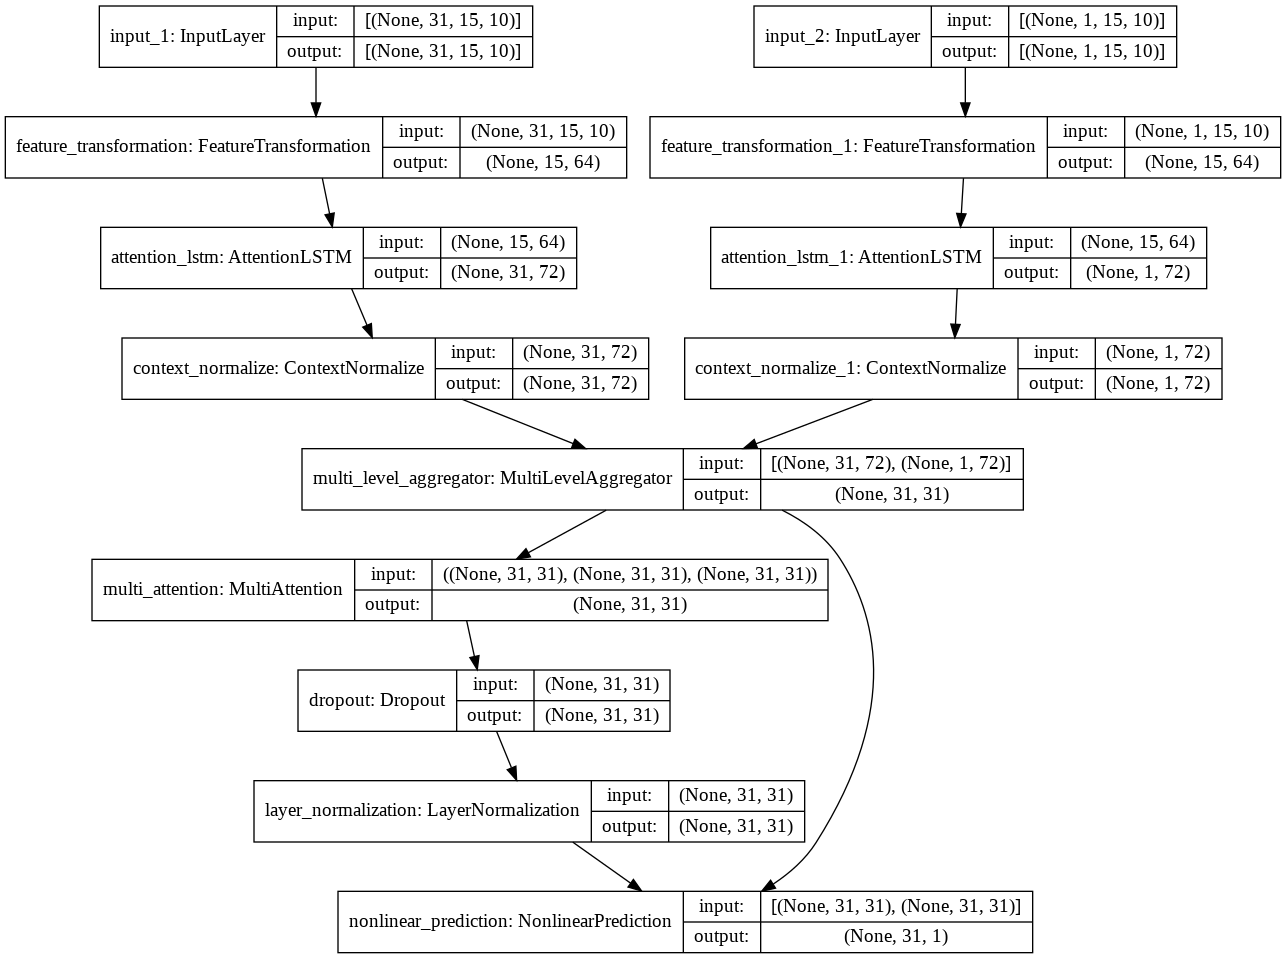

In [22]:
model = create_model()
plot_model(model, show_shapes=True, show_layer_names=True)

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 31, 15, 10)] 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1, 15, 10)]  0                                            
__________________________________________________________________________________________________
feature_transformation (Feature (None, 15, 64)       704         input_1[0][0]                    
__________________________________________________________________________________________________
feature_transformation_1 (Featu (None, 15, 64)       704         input_2[0][0]                    
______________________________________________________________________________________________

In [24]:
# callback = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/programmers/project/model/DTML.hdf5',
#                                               monitor='val_loss',
#                                               save_best_only=True, 
#                                               verbose=1)
mc =  tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/programmers/project/model/DTML.hdf5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)


history = model.fit([X_train_s, X_train_m], y_train_s,
                    batch_size=batch_size,
                    epochs=100,
                    # callbacks=es,
                    callbacks=[mc, es],
                    validation_data=([X_valid_s, X_valid_m], y_valid_s))


Epoch 1/100
87/87 [==============================] - 36s 294ms/step - loss: 0.7718 - accuracy: 0.4997 - mcc: -0.0062 - val_loss: 0.7205 - val_accuracy: 0.5282 - val_mcc: 0.0000e+00

Epoch 00001: val_accuracy improved from -inf to 0.52819, saving model to /content/drive/MyDrive/programmers/project/model/DTML.hdf5
Epoch 2/100
87/87 [==============================] - 24s 278ms/step - loss: 0.7441 - accuracy: 0.5031 - mcc: -0.0033 - val_loss: 0.7181 - val_accuracy: 0.5282 - val_mcc: 0.0000e+00

Epoch 00002: val_accuracy did not improve from 0.52819
Epoch 3/100
87/87 [==============================] - 24s 277ms/step - loss: 0.7355 - accuracy: 0.5072 - mcc: 0.0030 - val_loss: 0.7153 - val_accuracy: 0.5282 - val_mcc: 0.0000e+00

Epoch 00003: val_accuracy did not improve from 0.52819
Epoch 4/100
87/87 [==============================] - 24s 278ms/step - loss: 0.7282 - accuracy: 0.5068 - mcc: 0.0011 - val_loss: 0.7148 - val_accuracy: 0.5282 - val_mcc: 0.0000e+00

Epoch 00004: val_accuracy did no

In [25]:
train_pred = model.predict((X_train_s, X_train_m))
val_pred = model.predict((X_valid_s, X_valid_m))
test_pred = model.predict((X_test_s, X_test_m))

# #Print evaluation metrics for all datasets
train_eval = model.evaluate((X_train_s, X_train_m), y_train_m, verbose=0)
val_eval = model.evaluate((X_valid_s, X_valid_m), y_valid_m, verbose=0)
test_eval = model.evaluate((X_test_s, X_test_m), y_test_m, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, ACC: {:.4f}, MCC: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, ACC: {:.4f}, MCC: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, ACC: {:.4f}, MCC: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

 
Evaluation metrics
Training Data - Loss: 0.6443, ACC: 0.6357, MCC: 0.2718
Validation Data - Loss: 0.7768, ACC: 0.4927, MCC: -0.0007
Test Data - Loss: 0.7987, ACC: 0.4839, MCC: 0.0001


In [31]:
stock1 = []
for tp in test_pred[:20]:
  for i in range(len(tp)):
    if i == 0:
      stock1.append(tp[i])
    print(tp[i][0], end=" ")
  print()
label = []
for y_t in y_test_m[:20]:
  print(y_t[0], end=" ")
  label.append(y_t[0])

0.23834366 0.23418781 0.22086701 0.42925003 0.23075962 0.21919072 0.2209306 0.22805318 0.21979845 0.2192078 0.21987975 0.32509938 0.21934149 0.22235963 0.24360958 0.2209304 0.21948826 0.23311129 0.219684 0.28490138 0.225021 0.21925843 0.2192809 0.22388348 0.2197527 0.2192091 0.21954611 0.22227198 0.22309908 0.22101253 0.2816543 
0.45354572 0.4554921 0.227532 0.6829108 0.30334836 0.2524894 0.25849634 0.35072148 0.21953267 0.31450695 0.34248972 0.34370685 0.22237533 0.223007 0.47306204 0.223878 0.42202944 0.31333572 0.6394767 0.507522 0.6976152 0.29365212 0.6918935 0.69187886 0.50290096 0.47514048 0.25019985 0.7325886 0.24530628 0.22159034 0.28207833 
0.553072 0.467085 0.29261953 0.22824365 0.23583093 0.48229763 0.22093639 0.39347196 0.21969035 0.3163663 0.3785696 0.6297998 0.25876337 0.3025732 0.55357206 0.22344846 0.22140786 0.31307656 0.43320137 0.2454111 0.60371643 0.37285 0.60930085 0.44819063 0.5314585 0.2729841 0.2621131 0.6654406 0.34964257 0.22055408 0.46887833 
0.5310204 0.4879

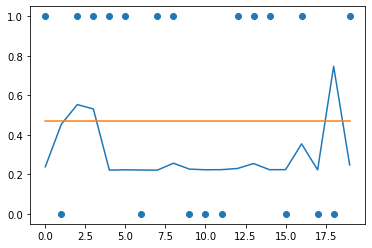

In [32]:
import matplotlib.pyplot as plt

plt.plot(stock1)
plt.plot([0.47 for _ in range(20)])
plt.scatter([i for i in range(20)], label)